# 주식 예측하기

## 1.데이터

### (1)데이터 준비

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/workplace/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

(2)전처리

In [13]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [14]:
# 로그 변환
ts_log = np.log(ts)

### (3)안정성 분석

In [15]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

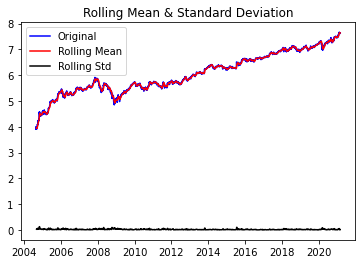

Results of Dickey-Fuller Test:
Test Statistic                   -1.878164
p-value                           0.342402
#Lags Used                        7.000000
Number of Observations Used    4156.000000
Critical Value (1%)              -3.431924
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


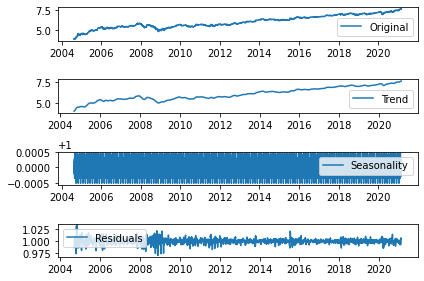

In [16]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [17]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.491272e+01
p-value                        1.450341e-27
#Lags Used                     3.000000e+01
Number of Observations Used    4.103000e+03
Critical Value (1%)           -3.431945e+00
Critical Value (5%)           -2.862245e+00
Critical Value (10%)          -2.567145e+00
dtype: float64


(4)데이터셋 준비

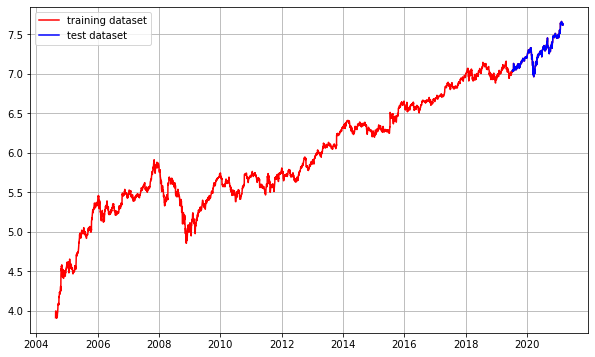

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

(5)ARIMA 모수 찾기

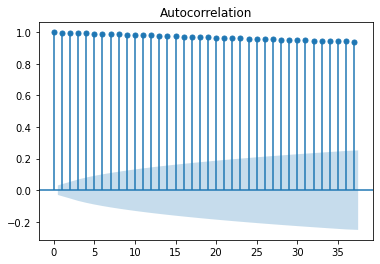

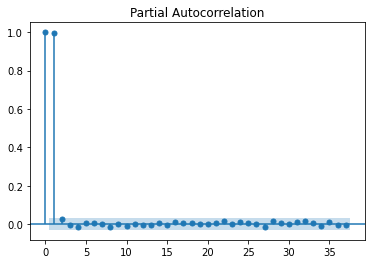

In [19]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -24.627639
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    4156.000000
Critical Value (1%)              -3.431924
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -20.554869
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4130.000000
Critical Value (1%)              -3.431934
Critical Value (5%)              -2.862240
Critical Value (10%)             -2.567143
dtype: float64


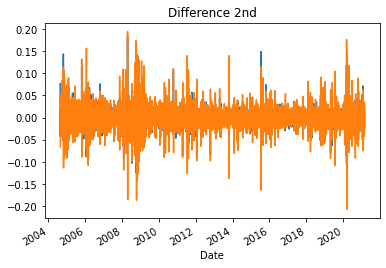

In [20]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 2.모델 훈련

In [21]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3746
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9554.331
Method:                       css-mle   S.D. of innovations              0.019
Date:                Fri, 05 Mar 2021   AIC                         -19102.661
Time:                        08:58:47   BIC                         -19083.976
Sample:                             1   HQIC                        -19096.016
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.666      0.008       0.000       0.001
ar.L1.D.Close     0.0106      0.016      0.651      0.515      -0.021       0.043
                                    Root

## 3.모델 테스트

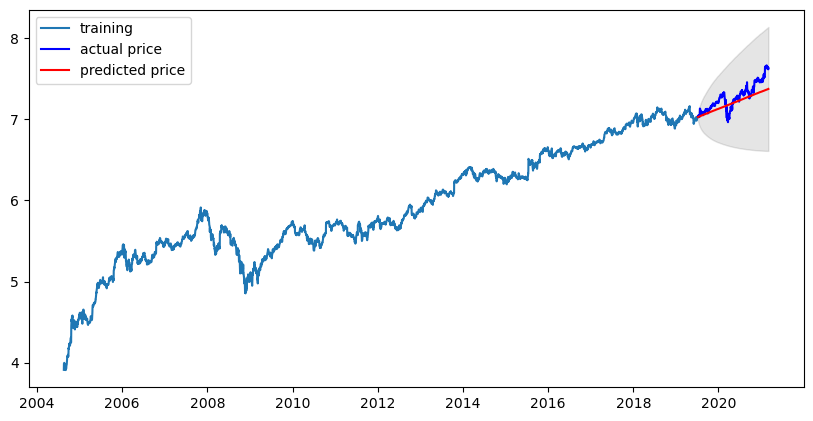

In [22]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  32914.25755209983
MAE:  136.56377291019345
RMSE:  181.42286942968306
MAPE: 8.64%


## 4.회고

모든 AI업계 종사자들의 신 구글갓의 주식을 살펴보았다. 물론 이전 데이터들뿐만이 아닌 매우 많은 변수가 존재하는 주식시장을 AI가 찾아낼 수 있을거라고는 생각하지 않지만 ~~미래에는 가능할지도~~ 최근들어 주식에 관심이 많았는데 이런 프로젝트를 하게 되서 매우 흥미로웠다. 이번에도 역시 개념지식들을 이해하는게 더 어려웠는데 빨리 데이터 시각화를 자유자재로 다룰 수 있는 날이 왔으면 좋겠다.